# Fronius 

## Settings

In [1]:
import requests
import json
import warnings
import datetime
import dateutil
import pandas as pd

import fronius
from fronius import FroniusInverter
from fronius import FroniusArchiveJson
from fronius import FroniusRealTimeJson


from IPython.display import display, HTML, Markdown
import matplotlib.pyplot as plt
import matplotlib

inverter_ip = "192.168.1.154"
inverter_installation_time = datetime.datetime(2017, 10, 11)


In [2]:
import imp
imp.reload(fronius)

<module 'fronius' from 'C:\\Users\\tomho\\PycharmProjects\\Fronius\\fronius\\fronius.py'>

# FroniusInverter object

The first object is _FroniusInverter_.  It will act as a proxy to the inverter hardware.   Create an instance by passing the hardware's IP address.

In [3]:
host = None
fi = FroniusInverter(inverter_ip)

This python module was tested against v1 of the Fronius API, and against v1.5-4 of the firmware.  Check if the server version is tested against.

In [4]:
compatible, response = fi.check_server_compatibility()
if compatible:
    display(Markdown("**Compatibility check: OK**"))
else:
    display(Markdown("**Compatibility check: NOK**"))

print("module supports API v"+ str(fi.api_version))
print("module tested against versions", fi.tested_server_versions)

print("Fronius version response:", response)

**Compatibility check: OK**

module supports API v1
module tested against versions ['1.5-4']
Fronius version response: {'APIVersion': 1, 'BaseURL': '/solar_api/v1/', 'CompatibilityRange': '1.5-4'}


# Reading real time data from the Fronius inverter

In [5]:
json = fi.get_inverter_realtime_data()
json

{'Body': {'Data': {'DAY_ENERGY': {'Unit': 'Wh', 'Values': {'1': 5846}},
   'PAC': {'Unit': 'W', 'Values': {'1': 314}},
   'TOTAL_ENERGY': {'Unit': 'Wh', 'Values': {'1': 200352}},
   'YEAR_ENERGY': {'Unit': 'Wh', 'Values': {'1': 200352}}}},
 'Head': {'RequestArguments': {'DeviceClass': 'Inverter', 'Scope': 'System'},
  'Status': {'Code': 0, 'Reason': '', 'UserMessage': ''},
  'Timestamp': '2017-10-29T13:26:43+01:00'}}

use the FroniusRealTimeJson class to access the json response. The data is marshalled in a pandas dataframe. Pass a label for the timestamp

In [6]:
frt = FroniusRealTimeJson(json)

if (frt.error_code() == 0):
    display(Markdown("**Realtime data call: OK**"))
    rtd = frt.data("ts")
    display(rtd)
else:
    display(Markdown("**Realtime data call: NOK**"))
    print(frt.error_status())


**Realtime data call: OK**

,ts,DAY_ENERGY,PAC,TOTAL_ENERGY,YEAR_ENERGY
0,2017-10-29 13:26:43+01:00,5846,314,200352,200352


pass previous realtime data to append the new observation to an existing dataframe

In [7]:
display(Markdown("**Example: Append new data to previous observations**"))

json2 = fi.get_inverter_realtime_data()
frt2 = FroniusRealTimeJson(json2)
rtd2 = frt2.data("ts", append=rtd)
rtd=rtd2
display(rtd2)

display(Markdown("**Example: Perform some calculations**"))
display(rtd2['DAY_ENERGY']/rtd2['TOTAL_ENERGY'])


**Example: Append new data to previous observations**

,ts,DAY_ENERGY,PAC,TOTAL_ENERGY,YEAR_ENERGY
0,2017-10-29 13:26:43+01:00,5846,314,200352,200352
1,2017-10-29 13:26:44+01:00,5846,315,200353,200352


**Example: Perform some calculations**

0    0.029179
1    0.029178
dtype: float64

Example : fetch some real time data and plot it

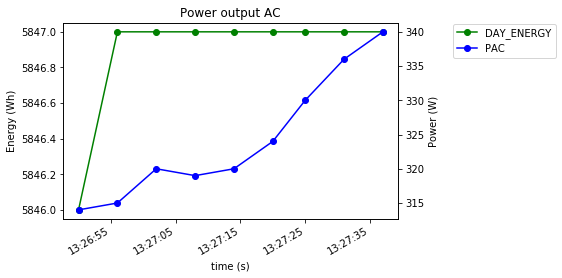

In [8]:
import time
# grab some more data
fi = FroniusInverter(inverter_ip)

d=None
for i in range (1, 10):
    time.sleep(5)
    json = fi.get_inverter_realtime_data()
    frt = FroniusRealTimeJson(json)
    d = frt.data("ts", append=d)

fig, ax1 = plt.subplots()

t=d["ts"]
s=d["DAY_ENERGY"]
lns1=ax1.plot(t, s, 'g-', marker='o')
ax1.set_ylabel('Energy (Wh)')

ax2 = ax1.twinx()

s2=d["PAC"]
lns2=ax2.plot(t, s2, 'b-', marker='o')
ax2.set_ylabel('Power (W)')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center left', bbox_to_anchor=(1.15, 0.91))


ax1.set(xlabel='time (s)',
       title='Power output AC')

plt.gcf().autofmt_xdate()

plt.show()

In [9]:
fi = FroniusInverter(inverter_ip)
fi.findEarliestData()

http://192.168.1.154/solar_api/v1/GetArchiveData.cgi 2017-09-01 00:00:00 -> 2017-09-15 00:00:00
http://192.168.1.154/solar_api/v1/GetArchiveData.cgi 2017-09-15 00:00:00 -> 2017-09-29 00:00:00
http://192.168.1.154/solar_api/v1/GetArchiveData.cgi 2017-09-29 00:00:00 -> 2017-10-13 00:00:00


datetime.datetime(2017, 10, 11, 15, 5, tzinfo=tzoffset(None, 7200))

In [12]:
fi = FroniusInverter(inverter_ip)
channels = fi.get_all_channels()

display(Markdown("**Defined channels**"))
display(channels)

**Defined channels**

['TimeSpanInSec',
 'Digital_PowerManagementRelay_Out_1',
 'EnergyReal_WAC_Sum_Produced',
 'Current_DC_String_1',
 'Current_DC_String_2',
 'Voltage_DC_String_1',
 'Voltage_DC_String_2',
 'Temperature_Powerstage',
 'Voltage_AC_Phase_1',
 'Voltage_AC_Phase_2',
 'Voltage_AC_Phase_3',
 'Current_AC_Phase_1',
 'Current_AC_Phase_2',
 'Current_AC_Phase_3',
 'PowerReal_PAC_Sum',
 'EnergyReal_WAC_Minus_Absolute',
 'EnergyReal_WAC_Plus_Absolute',
 'Meter_Location_Current',
 'Temperature_Channel_1',
 'Temperature_Channel_2',
 'Digital_Channel_1',
 'Digital_Channel_2',
 'Radiation',
 'Hybrid_Operating_State']

In [13]:
fi = FroniusInverter(inverter_ip)
data = fi.getHistoricalData(datetime.datetime.now() - datetime.timedelta(hours=1), datetime.datetime.now(), channels)
for key, value in data.items():
    display(Markdown("**"+str(key)+"**"))
    display(value)
    display(Markdown("\n"))



http://192.168.1.154/solar_api/v1/GetArchiveData.cgi 2017-10-29 12:30:06.810594 -> 2017-10-29 13:30:06.810594


**datamanager:/dc/f0056cc6/**

,ts,Digital_PowerManagementRelay_Out_1
0,2017-10-29 07:03:23+02:00,0
1,2017-10-29 07:07:15+02:00,0


**inverter/1**

,ts,Current_AC_Phase_1,Current_DC_String_1,Current_DC_String_2,EnergyReal_WAC_Sum_Produced,PowerReal_PAC_Sum,Temperature_Powerstage,TimeSpanInSec,Voltage_AC_Phase_1,Voltage_DC_String_1,Voltage_DC_String_2
0,2017-10-29 03:05:00+02:00,0.00,0.00,0.00,0.000000,0.000,NaN,46,NaN,1.2,0.9
1,2017-10-29 06:10:00+02:00,0.00,0.00,0.00,0.000000,0.000,NaN,68,NaN,1.1,0.8
2,2017-10-29 07:05:00+02:00,0.00,0.00,0.00,0.000000,0.000,NaN,53,NaN,10.8,10.7
3,2017-10-29 07:10:00+02:00,0.00,0.00,0.00,0.000000,0.000,NaN,218,NaN,22.1,22.0
4,2017-10-29 07:15:00+02:00,0.00,0.00,0.00,0.000000,0.000,0.0,297,0.0,71.0,56.4
5,2017-10-29 07:20:00+02:00,0.00,0.00,0.00,0.000000,0.000,0.0,302,0.0,173.0,75.8
6,2017-10-29 07:25:00+02:00,0.00,0.00,0.00,0.000000,0.000,0.0,297,0.0,201.6,82.1
7,2017-10-29 07:30:00+02:00,0.00,0.00,0.00,0.000000,0.000,0.0,302,0.0,204.8,82.9
8,2017-10-29 07:35:00+02:00,0.00,0.00,0.00,0.000000,0.000,0.0,297,0.0,222.5,87.3
9,2017-10-29 07:40:00+02:00,0.00,0.00,0.00,0.000000,0.000,0.0,302,0.0,260.8,100.0


In [14]:
fi = FroniusInverter(inverter_ip)
data = fi.getHistoricalDataJson(datetime.datetime.now() - datetime.timedelta(hours=1), datetime.datetime.now(), 
                            ["Digital_PowerManagementRelay_Out_1", "TimeSpanInSec"])

data


http://192.168.1.154/solar_api/v1/GetArchiveData.cgi 2017-10-29 12:30:18.458692 -> 2017-10-29 13:30:18.458692


{'Body': {'Data': {'datamanager:/dc/f0056cc6/': {'Data': {'Digital_PowerManagementRelay_Out_1': {'Unit': '1',
      'Values': {'25403': 0, '25635': 0},
      '_comment': 'channelId=123407124'}},
    'End': '2017-10-29T22:59:59+01:00',
    'Start': '2017-10-29T00:00:00+02:00'},
   'inverter/1': {'Data': {'TimeSpanInSec': {'Unit': 'sec',
      'Values': {'11100': 46,
       '22200': 68,
       '25500': 53,
       '25800': 218,
       '26100': 297,
       '26400': 302,
       '26700': 297,
       '27000': 302,
       '27300': 297,
       '27600': 302,
       '27900': 297,
       '28200': 302,
       '28500': 297,
       '28800': 302,
       '29100': 297,
       '29400': 302,
       '29700': 297,
       '30000': 302,
       '30300': 302,
       '30600': 297,
       '30900': 302,
       '31200': 297,
       '31500': 302,
       '31800': 297,
       '32100': 302,
       '32400': 297,
       '32700': 302,
       '33000': 297,
       '33300': 302,
       '33600': 297,
       '33900': 302,
    

## Fronius configuration

explores which channels are reported, and which channels remain empty

In [16]:
# setup the inverter object
fi = FroniusInverter(inverter_ip)

# fetch a a couple of days of recent data
all_channels = list(fi.get_all_channels())
jsondata=fi.getHistoricalDataJson(datetime.datetime.now() - datetime.timedelta(days=1), datetime.datetime.now(), all_channels)

# pass the 
faj = FroniusArchiveJson(jsondata)
data = faj.data()
devices = faj.device_ids()

channelsReported = []
for device in data:
    df=data[device]
    columns=list(df.columns)
    display(Markdown("**"+str(device)+"**"))
    for c in sorted(columns[1:]):
        print("\t", c)            
    channelsReported +=columns[1:]

missingChannels=all_channels
for c in channelsReported:
    missingChannels.remove(c)

display(Markdown("**"+str("Missing :")+"**"))
for c in sorted(missingChannels):
        print("\t", c) 

http://192.168.1.154/solar_api/v1/GetArchiveData.cgi 2017-10-28 13:30:50.313762 -> 2017-10-29 13:30:50.313762


**datamanager:/dc/f0056cc6/**

	 Digital_PowerManagementRelay_Out_1


**inverter/1**

	 Current_AC_Phase_1
	 Current_DC_String_1
	 Current_DC_String_2
	 EnergyReal_WAC_Sum_Produced
	 PowerReal_PAC_Sum
	 Temperature_Powerstage
	 TimeSpanInSec
	 Voltage_AC_Phase_1
	 Voltage_DC_String_1
	 Voltage_DC_String_2


**Missing :**

	 Current_AC_Phase_2
	 Current_AC_Phase_3
	 Digital_Channel_1
	 Digital_Channel_2
	 EnergyReal_WAC_Minus_Absolute
	 EnergyReal_WAC_Plus_Absolute
	 Hybrid_Operating_State
	 Meter_Location_Current
	 Radiation
	 Temperature_Channel_1
	 Temperature_Channel_2
	 Voltage_AC_Phase_2
	 Voltage_AC_Phase_3


# daily graphs

In [17]:
# setup the inverter object
fi = FroniusInverter(inverter_ip)

channels = ["Current_DC_String_1", "Current_DC_String_2"]
channels = [ "Current_DC_String_2"]

# fetch a a couple of days of recent data
day=datetime.datetime(year=2017, month=10, day=1)
duration = 30

data20171020 = fi.getHistoricalData(day, day + datetime.timedelta(days=duration) -datetime.timedelta(seconds=1))


http://192.168.1.154/solar_api/v1/GetArchiveData.cgi 2017-10-01 00:00:00 -> 2017-10-16 23:59:59
http://192.168.1.154/solar_api/v1/GetArchiveData.cgi 2017-10-17 00:00:00 -> 2017-10-30 23:59:59


C:\Users\tomho\PycharmProjects\Fronius\fronius\fronius.py:247: UserWarning: class method FroniusArchiveJson::timestamp_colname depricated
  warnings.warn("class method FroniusArchiveJson::timestamp_colname depricated")


In [18]:
data20171020_json = fi.getHistoricalDataJson(day, day + datetime.timedelta(days=duration) -datetime.timedelta(seconds=1))
data20171020_json

http://192.168.1.154/solar_api/v1/GetArchiveData.cgi 2017-10-01 00:00:00 -> 2017-10-30 23:59:59


{'Body': {'Data': {}},
 'Head': {'RequestArguments': {'Channel': 'Hybrid_Operating_State',
   'EndDate': '2017-10-30T23:59:59+01:00',
   'HumanReadable': 'True',
   'Scope': 'System',
   'SeriesType': 'Detail',
   'StartDate': '2017-10-01T00:00:00+02:00'},
  'Status': {'Code': 255,
   'ErrorDetail': {'Nodes': []},
   'Reason': 'Query interval is restricted to 16 days',
   'UserMessage': ''},
  'Timestamp': '2017-10-29T13:31:39+01:00'}}

In [19]:
data20171020_json

{'Body': {'Data': {}},
 'Head': {'RequestArguments': {'Channel': 'Hybrid_Operating_State',
   'EndDate': '2017-10-30T23:59:59+01:00',
   'HumanReadable': 'True',
   'Scope': 'System',
   'SeriesType': 'Detail',
   'StartDate': '2017-10-01T00:00:00+02:00'},
  'Status': {'Code': 255,
   'ErrorDetail': {'Nodes': []},
   'Reason': 'Query interval is restricted to 16 days',
   'UserMessage': ''},
  'Timestamp': '2017-10-29T13:31:39+01:00'}}

In [20]:
inverterData = data20171020['inverter/1']
inverterData

,ts,Current_AC_Phase_1,Current_DC_String_1,Current_DC_String_2,EnergyReal_WAC_Sum_Produced,PowerReal_PAC_Sum,Temperature_Powerstage,TimeSpanInSec,Voltage_AC_Phase_1,Voltage_DC_String_1,Voltage_DC_String_2
655,2017-10-11 15:05:00+02:00,3.00,1.34,1.25,42.044444,671.400,19.0,350,223.8,354.4,137.3
656,2017-10-11 15:10:00+02:00,3.11,1.39,1.25,59.759722,718.099,22.0,299,230.9,397.3,155.0
657,2017-10-11 15:15:00+02:00,2.14,1.01,0.89,11.019722,467.804,25.0,174,218.6,389.4,149.8
658,2017-10-11 15:20:00+02:00,2.34,1.06,1.00,45.524444,541.008,27.0,302,231.2,393.8,149.2
659,2017-10-11 15:25:00+02:00,2.46,1.11,1.05,47.938333,568.752,29.0,302,231.2,394.7,148.5
660,2017-10-11 15:30:00+02:00,2.76,1.24,1.11,52.595278,636.732,31.0,297,230.7,396.7,152.3
661,2017-10-11 15:35:00+02:00,2.78,1.26,1.10,53.976667,641.624,33.0,302,230.8,396.3,153.5
662,2017-10-11 15:40:00+02:00,2.29,1.06,0.89,43.893611,531.280,35.0,297,232.0,393.9,154.4
663,2017-10-11 15:45:00+02:00,2.59,1.17,1.05,50.237222,598.808,37.0,302,231.2,394.6,153.5
664,2017-10-11 15:50:00+02:00,3.86,1.63,1.76,74.232500,897.064,37.0,297,232.4,400.3,158.3


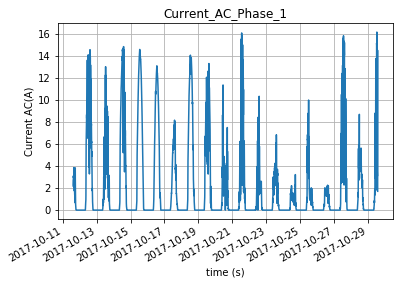

In [21]:
fig, ax = plt.subplots()

d=inverterData
t=d["ts"]
s=d["Current_AC_Phase_1"]
ax.plot(t, s)

ax.set(xlabel='time (s)', ylabel='Current AC(A)',
       title='Current_AC_Phase_1')
ax.grid()
plt.gcf().autofmt_xdate()

plt.show()

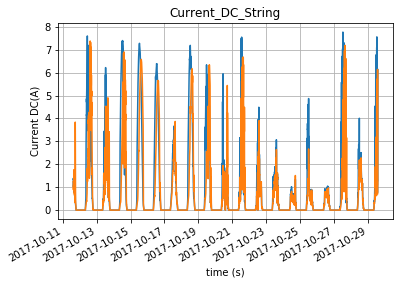

In [22]:
fig, ax = plt.subplots()

d=inverterData
#d=(d.sort_values('ts'))
t=d["ts"]
s1=d["Current_DC_String_1"]
ax.plot(t, s1)

s2=d["Current_DC_String_2"]
ax.plot(t, s2)

ax.set(xlabel='time (s)', ylabel='Current DC(A)',
       title='Current_DC_String')
ax.grid()
plt.gcf().autofmt_xdate()


plt.show()

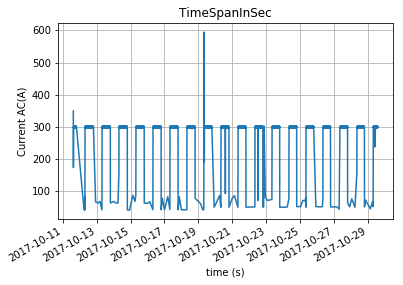

In [23]:
fig, ax = plt.subplots()

d=inverterData
#d=(d.sort_values('ts'))
t=d["ts"]
s=d["TimeSpanInSec"]
ax.plot(t, s)

ax.set(xlabel='time (s)', ylabel='Current AC(A)',
       title='TimeSpanInSec')
ax.grid()
plt.gcf().autofmt_xdate()


plt.show()

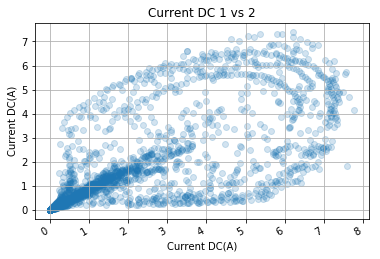

In [24]:
fig, ax = plt.subplots()

d=inverterData
#d=(d.sort_values('ts'))
t=d["ts"]
s1=d["Current_DC_String_1"]
s2=d["Current_DC_String_2"]

ax.scatter(s1, s2, alpha=.2)

ax.set(xlabel='Current DC(A)', ylabel='Current DC(A)',
       title='Current DC 1 vs 2')
ax.grid()
plt.gcf().autofmt_xdate()


plt.show()

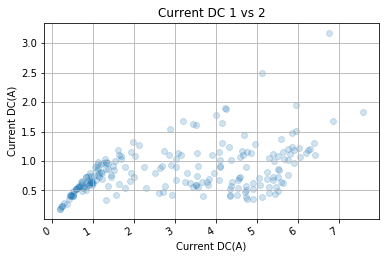

In [25]:
fig, ax = plt.subplots()

d=inverterData
#d=(d.sort_values('ts'))
d['tod'] = d.ts.apply(lambda t : t.hour)

d=d[d.tod == 10]

s1=d["Current_DC_String_1"]
s2=d["Current_DC_String_2"]

ax.scatter(s1, s2, alpha=.2)

ax.set(xlabel='Current DC(A)', ylabel='Current DC(A)',
       title='Current DC 1 vs 2')
ax.grid()
plt.gcf().autofmt_xdate()


plt.show()

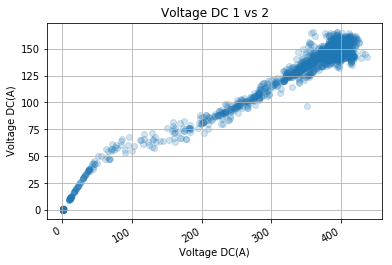

In [26]:
fig, ax = plt.subplots()

d=inverterData
#d=(d.sort_values('ts'))
t=d["ts"]
s1=d["Voltage_DC_String_1"]
s2=d["Voltage_DC_String_2"]

ax.scatter(s1, s2, alpha=.2)

ax.set(xlabel='Voltage DC(A)', ylabel='Voltage DC(A)',
       title='Voltage DC 1 vs 2')
ax.grid()
plt.gcf().autofmt_xdate()


plt.show()

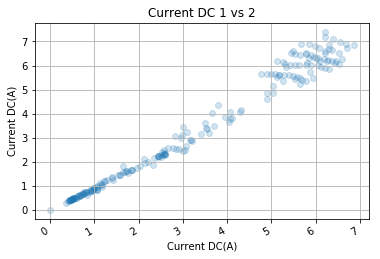

In [27]:
fig, ax = plt.subplots()

d=inverterData
#d=(d.sort_values('ts'))
d['Current_DC'] = d["Current_DC_String_1"] + d["Current_DC_String_2"]

d=d[d.tod == 14]

s1=d["Current_DC_String_1"]
s2=d["Current_DC_String_2"]

ax.scatter(s1, s2, alpha=.2)

ax.set(xlabel='Current DC(A)', ylabel='Current DC(A)',
       title='Current DC 1 vs 2')
ax.grid()
plt.gcf().autofmt_xdate()


plt.show()